## This notebook allows you to apply EQTransformer (by way of Seisbench) to continuous seismic data from the AACSE network, and retrieve picks for the specified time period. The waveforms can also be filtered or denoised by DeepDenoiser (by way of Seisbench).

## This workflow could be edited to be used with different seismic stations.

#### Create the environment with all needed packages. NOTE: will need to restart your kernel and specify the new environment.

In [ ]:
!conda env create --quiet -f environment.yml

#### Import all needed packages

In [1]:
import datetime
import json
import logging
from datetime import timedelta

import alaska_utils
import dask
import eqt_utils
import matplotlib.pyplot as plt
import numpy as np
import obspy
import pandas as pd
import postprocess
import requests
import seisbench
import seisbench.models as sbm
import geopandas as gpd

# Progress bar for dask operations:
from dask.diagnostics import ProgressBar
from obspy.clients.fdsn import Client

pbar = dask.diagnostics.ProgressBar()
pbar.register()

import warnings

warnings.filterwarnings("ignore")

#### Choose window length (s), and start and end times

In [19]:
waveform_length = 60
waveform_overlap = 0
starttime = datetime.datetime(2019, 5, 27, 5)
endtime = datetime.datetime(2019, 5, 27, 6)

#### Load list of stations to run the workflow on, specify by network and maximum station elevation if desired

In [20]:
# Pre=saved station list in pandas dataframe format
dfS = pd.read_parquet(
    "https://github.com/zoekrauss/alaska_catalog/raw/main/data_acquisition/alaska_stations.parquet"
)
dfS = alaska_utils.station_list(dfS,starttime,endtime,elevation=False,network=False)

#### Specify whether to apply any filtering to the waveforms before phase picking

This choice is made with the variable filt_type.

filt_type = 0 for raw waveforms\
filt_type = 1 for bandpass filtered waveforms\
filt_type = 2 to apply DeepDenoiser to the waveforms

NOTE: if specifying bandpass filter, must also specify f1 and f2 for bandpass limits

In [21]:
filt_type = 1
f1 = 5
f2 = 20

### Run the workflow, and output:
#### (1) pandas dataframe of all pick metadata
#### (2) list of pick dictionaries formatted for use with GAMMA

In [22]:
%%time

pick_info,gamma_picks = eqt_utils.ml_pick(
    dfS, starttime, endtime, waveform_length, waveform_overlap, filt_type, f1=f1, f2=f2
)

[########################################] | 100% Completed |  8min 26.2s
Status: filtering data
Status: applying EQTransformer


2022-03-14 19:39:19,590 | seisbench | WARNING | Parts of the input stream consist of fragments shorter than the number of input samples. Output might be empty.
2022-03-14 19:39:28,343 | seisbench | WARNING | Parts of the input stream consist of fragments shorter than the number of input samples. Output might be empty.
2022-03-14 19:39:38,673 | seisbench | WARNING | Parts of the input stream consist of fragments shorter than the number of input samples. Output might be empty.
2022-03-14 19:39:57,119 | seisbench | WARNING | Parts of the input stream consist of fragments shorter than the number of input samples. Output might be empty.
2022-03-14 19:40:07,418 | seisbench | WARNING | Parts of the input stream consist of fragments shorter than the number of input samples. Output might be empty.
2022-03-14 19:40:16,099 | seisbench | WARNING | Parts of the input stream consist of fragments shorter than the number of input samples. Output might be empty.
2022-03-14 19:40:16,870 | seisbench | WA

CPU times: user 36min 49s, sys: 36.3 s, total: 37min 26s
Wall time: 18min 22s


#### Below is an example of the output pick dataframe. You can see that both the raw and denoised SNR of the pick is saved for all channels, as well as the raw and denoised amplitude of the signal (for use in magnitude estimation with GAMMA), and the probability of the pick from EQTransformer.

In [10]:
pick_info.head()

,id,network,station,channel,phase,timestamp,prob,raw_amp,den_amp,z_raw_snr,z_den_snr,n_raw_snr,n_den_snr,e_raw_snr,e_den_snr
0,XO.LT01..HH,XO,LT01,HH,P,2019-05-27T10:30:37.732,0.752095,648952.689879,648952.689879,4011.344725,4011.344725,30.355588,30.355588,4.157171,4.157171
1,XO.WD50..HH,XO,WD50,HH,S,2019-05-27T10:30:16.599,0.459192,1955.728113,1955.728113,10.512972,10.512972,28.186199,28.186199,18.069943,18.069943
2,XO.WD60..HH,XO,WD60,HH,P,2019-05-27T10:31:05.290,0.508050,133.822785,133.822785,1.159726,1.159726,1.253658,1.253658,3.357883,3.357883
3,XO.WD60..HH,XO,WD60,HH,S,2019-05-27T10:31:31.200,0.340008,338.774845,338.774845,14.632777,14.632777,14.776297,14.776297,15.755255,15.755255
4,XO.WD48..HH,XO,WD48,HH,P,2019-05-27T10:32:05.274,0.466154,106.377301,106.377301,0.406411,0.406411,2.282273,2.282273,2.281416,2.281416


### A great way to save these results is in parquet format, which is an efficient way to store tabular data.

In [15]:
pick_info.to_parquet("picks_20190527_1030_bp0535.parquet", version="2.6")

# Nice! Now we can do some performance evaluation.

### We load in the manually-constructed catalog for the same stations, and compare it to the machine learning picks to evaluate performance. 

We have stored the catalog in an easily readable format, parquet, hosted on my personal github. The catalog was downloaded from https://scholarworks.alaska.edu/handle/11122/11967 and then converted locally.  

In [12]:
# Load master pick and event lists
ground_truth = pd.read_parquet('https://github.com/zoekrauss/alaska_catalog/raw/main/data_acquisition/alaska_picks.parquet')
events = pd.read_parquet('https://github.com/zoekrauss/alaska_catalog/raw/main/data_acquisition/alaska_events.parquet')
ground_truth['og_timestamp']=pd.to_datetime(ground_truth['og_timestamp'],format='%Y-%m-%dT%H:%M:%S.%fZ',errors='coerce')
events['time']=pd.to_datetime(events['time'],format='%Y-%m-%dT%H:%M:%S.%fZ',errors='coerce')

### Let's see which picks are true positives by joining based on phase type, station code, and time residual within a threshold.

In [13]:
df = pick_info
df['timestamp']=pd.to_datetime(df['timestamp'],infer_datetime_format=True)
df['type'] = [t.lower() for t in df['phase']]

resid_max = 0.1 # seconds

# Let's only compare the part of the original catalog that we have EQT picks for:
cat_start = min(df['timestamp'] - pd.Timedelta(30,'seconds'))
cat_end = max(df['timestamp'] + pd.Timedelta(30,'seconds'))
ground_truth = ground_truth[(ground_truth['og_timestamp'] > cat_start) & (ground_truth['og_timestamp'] < cat_end)]
# Also only compare picks on stations that are in our station list:
ground_truth = ground_truth[([t in df['id'].to_list() for t in ground_truth['sta_code']])]

# Sort both dataframes by time:
df.sort_values(by=['timestamp'],inplace=True)
ground_truth.sort_values(by=['og_timestamp'],inplace=True)

# Merge dataframes, only merging picks if they have matching station ID, 
# phase type, and are within 0.1 s of each other
comp = pd.merge_asof(left=df,right=ground_truth,left_on=['timestamp'],right_on=['og_timestamp'],left_by=['id','type'],right_by=['sta_code','og_phase'],tolerance = pd.Timedelta(resid_max,'seconds'),direction='nearest')

# Add residual column: 
comp['pick_resid'] = comp['og_timestamp'] - comp['timestamp']
comp['pick_resid'] = comp['pick_resid'].dt.total_seconds()

### Using that merged dataframe, we can print out performance statistics. 

In [14]:
true_positives = comp['og_timestamp'].notna().sum()

false_positives = comp['og_timestamp'].isna().sum()

false_negatives = len(ground_truth)-true_positives

print('There were ' + str(true_positives) + ' true positives.')
print('There were ' + str(false_positives) + ' false positives.')
print('There were ' + str(false_negatives) + ' false negatives.')

precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
f1 = 2 * ((precision * recall)/(precision + recall))

print('This yields a precision of ' + str(round(precision,2)) + ', a recall of ' + str(round(recall,2)) + ', and an F1-score of ' + str(round(f1,2)) + '.')

There were 2 true positives.
There were 26 false positives.
There were 190 false negatives.
This yields a precision of 0.07, a recall of 0.01, and an F1-score of 0.02.


### Which earthquakes occurred during this period that we should be getting picks for?

In [15]:
events = pd.read_parquet('https://github.com/zoekrauss/alaska_catalog/raw/main/data_acquisition/alaska_events.parquet')
events['time']=pd.to_datetime(events['time'],format='%Y-%m-%dT%H:%M:%S.%fZ',errors='coerce')
events = events[(events['time'] > cat_start) & (events['time'] < cat_end)]

gf = gpd.GeoDataFrame(events.drop(columns='time').copy(), 
                      geometry=gpd.points_from_xy(events.longitude,events.latitude),
                      crs=4326)
gf.explore(column='magnitude')

### How are picks distributed throughout time, in comparison to the original catalog?

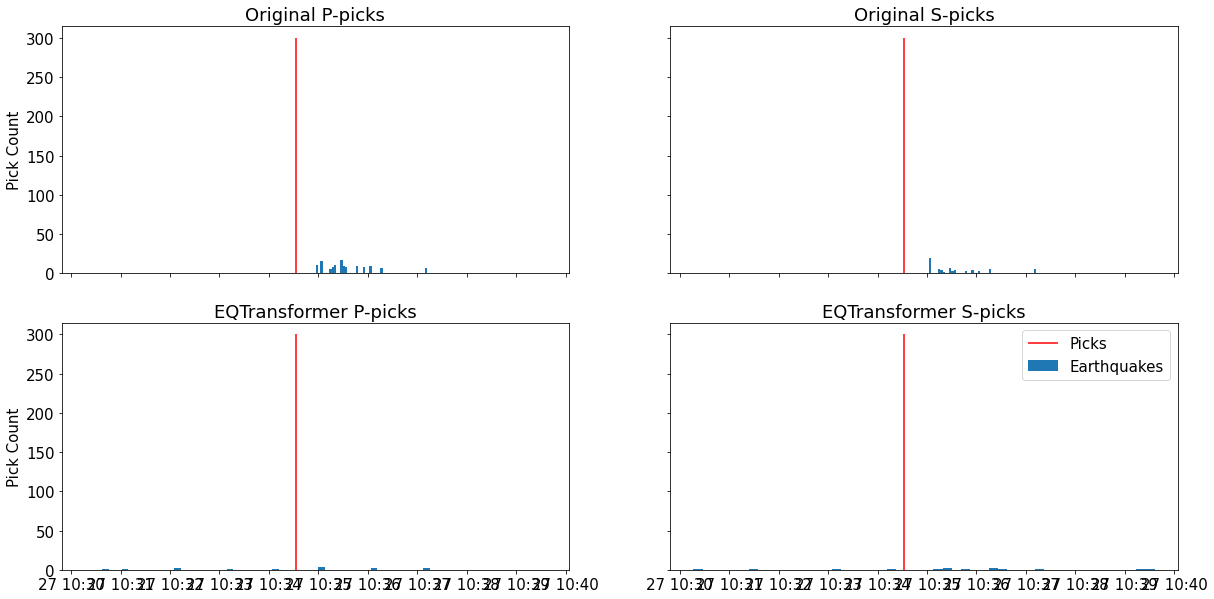

In [18]:
plt.rcParams.update({'font.size': 15})

php_picks = df[df['type']=='p']
phs_picks = df[df['type']=='s']

p_picks = ground_truth[ground_truth['og_phase']=='p']
s_picks = ground_truth[ground_truth['og_phase']=='s']

nbins= 50

# Filter by probability?

fig, axs = plt.subplots(2,2, figsize=(20,10),sharex=True,sharey=True)
axs[0,0].hist(p_picks['og_timestamp'],bins=nbins);
axs[0,0].vlines(x=events['time'],ymin=0,ymax=300,colors ='r')
axs[0,0].set_title('Original P-picks')
axs[0,0].set_ylabel('Pick Count')
axs[0,1].hist(s_picks['og_timestamp'],bins=nbins);
axs[0,1].vlines(x=events['time'],ymin=0,ymax=300,colors ='r')
axs[0,1].set_title('Original S-picks')
axs[1,0].hist(php_picks['timestamp'],bins=nbins);
axs[1,0].set_title('EQTransformer P-picks')
axs[1,0].set_ylabel('Pick Count')
axs[1,0].vlines(x=events['time'],ymin=0,ymax=300,colors ='r')
axs[1,1].hist(phs_picks['timestamp'],bins=nbins);
axs[1,1].set_title('EQTransformer S-picks')
axs[1,1].vlines(x=events['time'],ymin=0,ymax=300,colors ='r')
axs[1,1].legend(['Picks','Earthquakes'])



### How are EQTransformer probabilities distributed throughout all of the picks, throughout time relative to earthquakes, and for true picks specifically?

#### A great way to look at all of this at once is a scatter plot of picks throughout time.

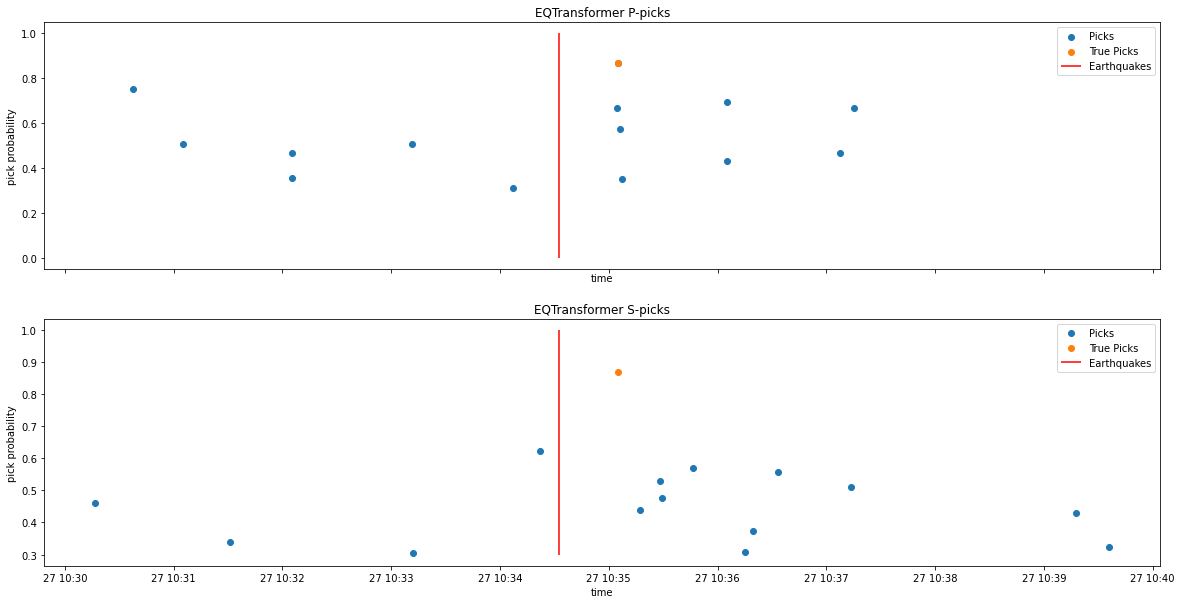

In [16]:
events = pd.read_parquet('https://github.com/zoekrauss/alaska_catalog/raw/main/data_acquisition/alaska_events.parquet')
events['time']=pd.to_datetime(events['time'],format='%Y-%m-%dT%H:%M:%S.%fZ',errors='coerce')
events = events[(events['time'] > cat_start) & (events['time'] < cat_end)]

true_positives = comp[comp['og_timestamp'].notna()]

php_picks = df[df['type']=='p']
phs_picks = df[df['type']=='s']

p_picks = ground_truth[ground_truth['og_phase']=='p']
s_picks = ground_truth[ground_truth['og_phase']=='s']

true_p = true_positives[true_positives['type']=='p']
true_s = true_positives[true_positives['type']=='p']

nbins= 50

# Filter by probability?
fig, axs = plt.subplots(2,1, figsize=(20,10),sharex=True)

axs[0].scatter(php_picks['timestamp'],php_picks['prob'])
axs[0].scatter(true_p['timestamp'],true_p['prob'])
axs[0].vlines(x=events['time'],ymin=0,ymax=1,colors ='r')
axs[0].set_xlabel('time')
axs[0].set_ylabel('pick probability')
axs[0].set_title('EQTransformer P-picks')
axs[0].legend(['Picks','True Picks','Earthquakes'])

axs[1].scatter(phs_picks['timestamp'],phs_picks['prob'])
axs[1].scatter(true_s['timestamp'],true_s['prob'])
axs[1].vlines(x=events['time'],ymin=0.3,ymax=1,colors ='r')
axs[1].set_xlabel('time')
axs[1].set_ylabel('pick probability')
axs[1].set_title('EQTransformer S-picks')
axs[1].legend(['Picks','True Picks','Earthquakes'])